#                          REAL-TIME FORECAST
##              Predicting Hourly Electricity Consumption

## LIBRARIES

In [10]:
import pandas as pd
import datetime as dt
import urllib
import json
import seaborn as sns
import matplotlib.pyplot as plt

## DATA EXTRACTION

### Fetching Past Electricity Consumption Data for the US city : Homestead(HST)

In [2]:
key = 'dd77e4c78c49c7b78faa3d08a9f429ee' # API Key

# URL url_string to access the data
url_string = 'https://api.eia.gov/series/?api_key=%s&series_id=EBA.HST-ALL.D.H'%key

# Open the URL url_string, which is a string.
url = urllib.request.urlopen(url_string)

# Reading JSON File from url
data = json.loads(url.read().decode())

# Accessing data of hourly consumption of Electricity 
data = data['series'][0]['data']

### Preparing Pandas DataFrame with two columns as Date and Consumption

In [3]:
# Initialising Dataframe having columns as Date and Consumption
DataFrame_data = pd.DataFrame(columns=['Date','Consumption'])
DataFrame_data['Consumption'] = DataFrame_data['Consumption'].astype(float)

### Adding List of two elements(Date,Consumption) to pandas dataframe

In [4]:
# data is a list of lists in which each list contain two elements [date and time,consumption of electricity]
for em in data:

    TimeStamp_String = em[0]
    Consumption_val  = em[1]
    
    # Consumption can't be null
    if(Consumption_val != None):
        # Consumption to floating-point numbers which is useful in further analysis
        consumption = float(int(Consumption_val)*1.00)
        # Adding data_row to dataframe
        data_row = [TimeStamp_String,consumption]
        DataFrame_data.loc[-1,:] = data_row
        DataFrame_data.index += 1

In [5]:
DataFrame_data.head()

,Date,Consumption
43515,20200815T05Z,80.0
43514,20200815T03Z,93.0
43513,20200815T02Z,100.0
43512,20200815T01Z,106.0
43511,20200815T00Z,108.0


### Analysing Consumption Pattern with Time  

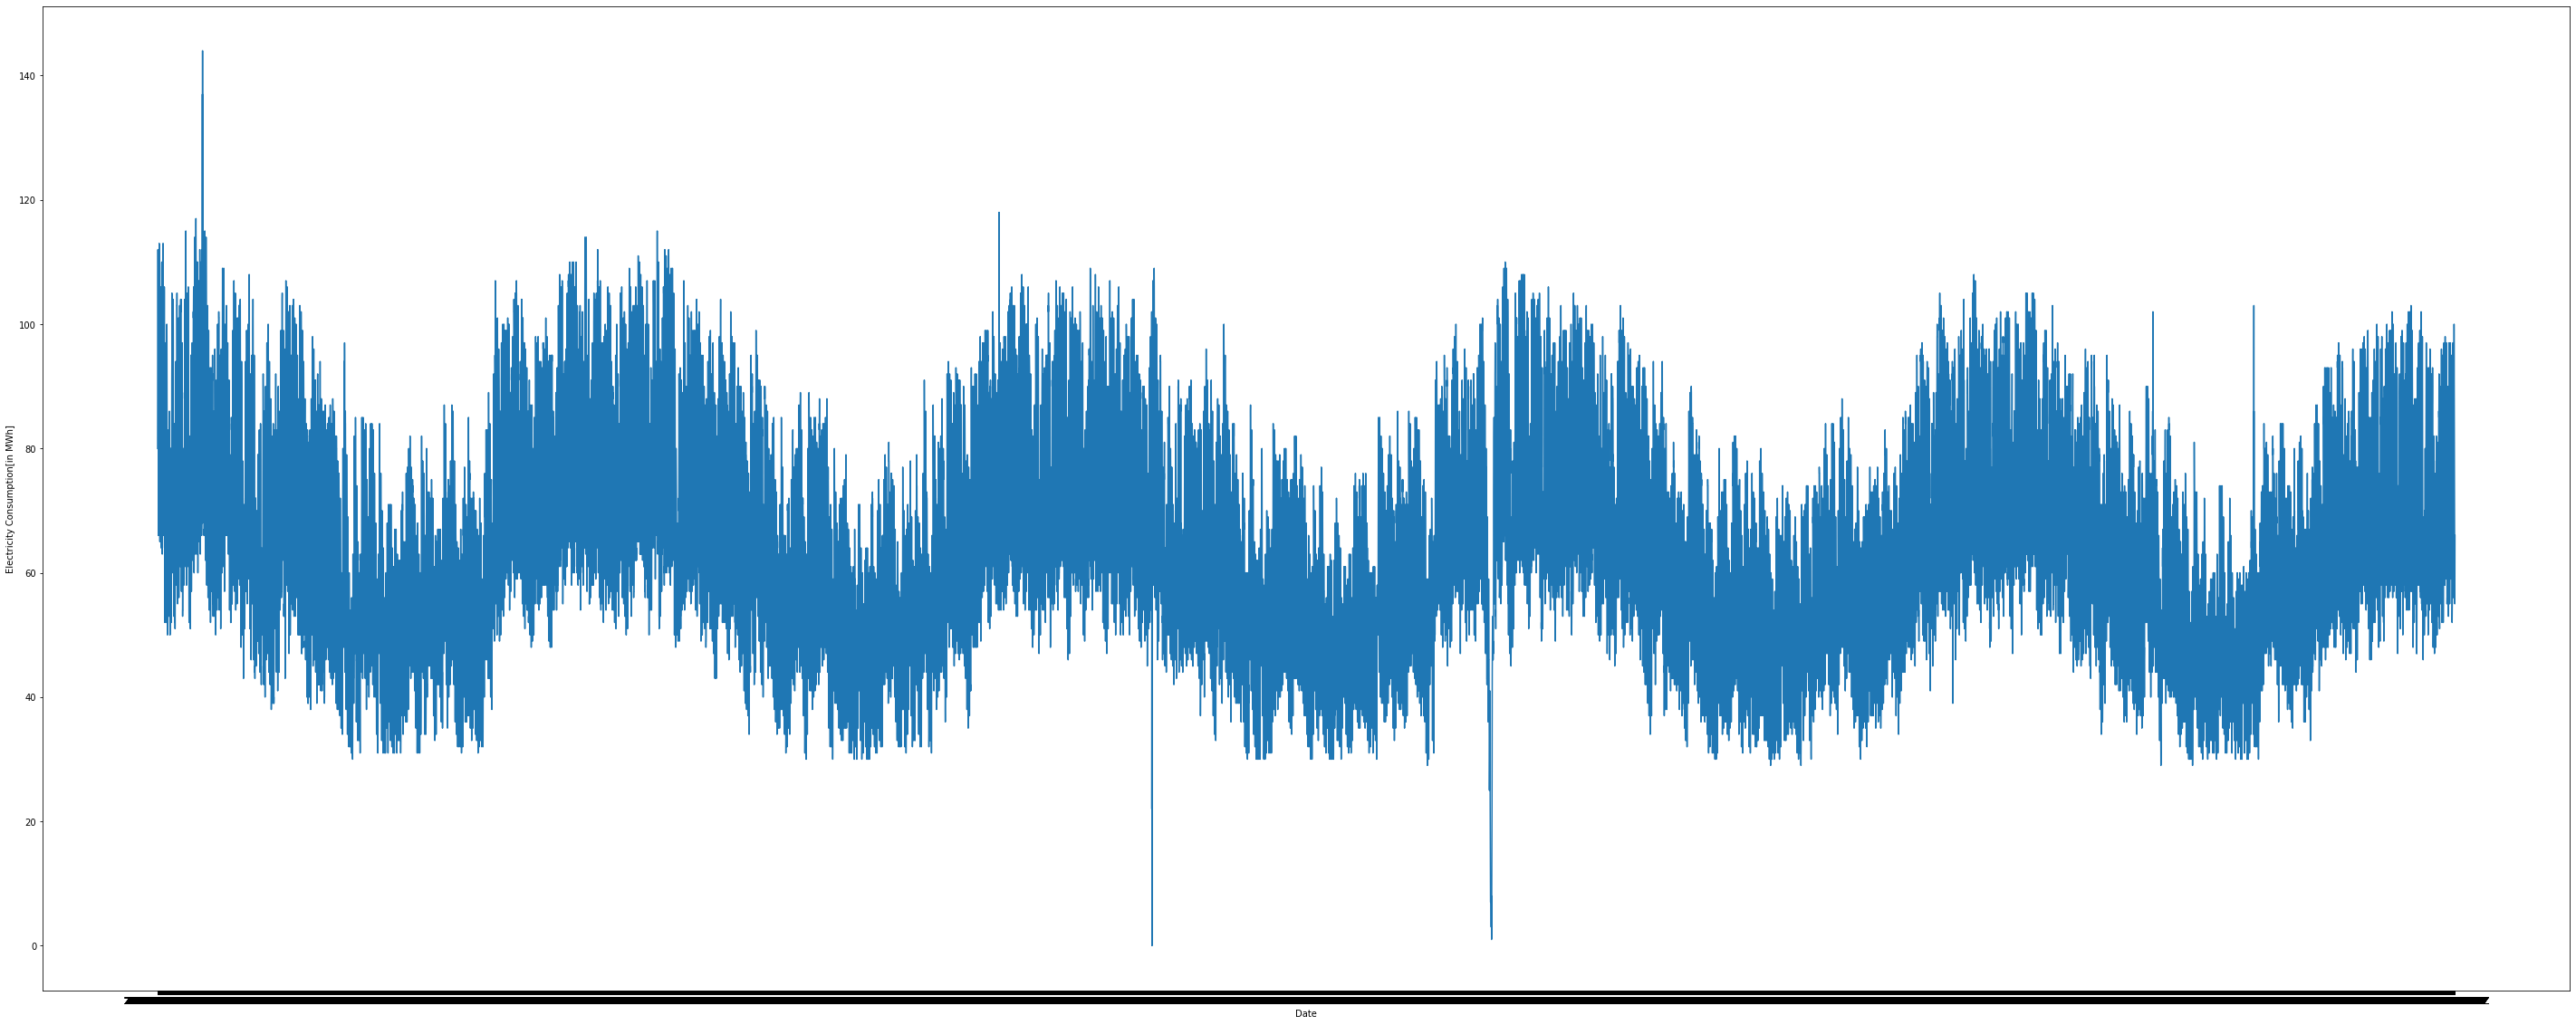

In [27]:
fig,ax = plt.subplots(figsize = (50,20))                       # Create a figure and a set of subplots.
plt.ylabel('Electricity Consumption[in MWh]') # labelling Y-axis
plt.xlabel('Date')                            # labelling X-axis
ax.plot(DataFrame_data['Date'],DataFrame_data['Consumption'])
plt.show()

### Fething Historical Weather Data using WorldWeatherOnline API

In [33]:
# Installing WorldWeatherOnline weather data API wrapper
!pip3 install wwo-hist

  Using cached https://files.pythonhosted.org/packages/5a/b4/19a4d6a0d131567cf4b2ffa3758710d867f7d7d3f0c6f94bd63fadf1d02a/wwo_hist-0.0.5-py3-none-any.whl


In [34]:
# Import Package 
from wwo_hist import retrieve_hist_data

In [35]:
# Retrieving data until today from 11 dec 2017
frequency=1
start_date = '11-DEC-2017'
today_date = dt.date.today()
end_date = today_date
api_key = 'a272d49bf37c42508c982909200407'
location_list = ['Homestead']

hist_weather_data = retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = True,
                                export_csv = False,
                                store_df = True)



Retrieving weather data for Homestead


Currently retrieving data for Homestead: from 2017-12-11 to 2017-12-31
Time elapsed (hh:mm:ss.ms) 0:00:06.065228
Currently retrieving data for Homestead: from 2018-01-01 to 2018-01-31
Time elapsed (hh:mm:ss.ms) 0:00:11.172081
Currently retrieving data for Homestead: from 2018-02-01 to 2018-02-28
Time elapsed (hh:mm:ss.ms) 0:00:15.896507
Currently retrieving data for Homestead: from 2018-03-01 to 2018-03-31
Time elapsed (hh:mm:ss.ms) 0:00:20.909105
Currently retrieving data for Homestead: from 2018-04-01 to 2018-04-30
Time elapsed (hh:mm:ss.ms) 0:00:25.664387
Currently retrieving data for Homestead: from 2018-05-01 to 2018-05-31
Time elapsed (hh:mm:ss.ms) 0:00:30.895405
Currently retrieving data for Homestead: from 2018-06-01 to 2018-06-30
Time elapsed (hh:mm:ss.ms) 0:00:36.400488
Currently retrieving data for Homestead: from 2018-07-01 to 2018-07-31
Time elapsed (hh:mm:ss.ms) 0:00:41.419242
Currently retrieving data for Homestead: from 2018-08-

In [47]:
# dataframe with hourly weather data from WorldWeatherOnline
weather_DataFrame = hist_weather_data[0]
weather_DataFrame.head()

,date_time,Homestead_maxtempC,Homestead_mintempC,Homestead_totalSnow_cm,Homestead_sunHour,Homestead_uvIndex,Homestead_moon_illumination,Homestead_moonrise,Homestead_moonset,Homestead_sunrise,...,Homestead_WindGustKmph,Homestead_cloudcover,Homestead_humidity,Homestead_precipMM,Homestead_pressure,Homestead_tempC,Homestead_visibility,Homestead_winddirDegree,Homestead_windspeedKmph,Homestead_location
0,2017-12-11 00:00:00,19,10,0.0,10.8,4,41,02:04 AM,02:33 PM,07:58 AM,...,30,1,58,0.0,1024,11,10,338,18,Homestead
1,2017-12-11 01:00:00,19,10,0.0,10.8,4,41,02:04 AM,02:33 PM,07:58 AM,...,30,1,58,0.0,1024,11,10,339,18,Homestead
2,2017-12-11 02:00:00,19,10,0.0,10.8,4,41,02:04 AM,02:33 PM,07:58 AM,...,30,0,59,0.0,1024,11,10,341,18,Homestead
3,2017-12-11 03:00:00,19,10,0.0,10.8,4,41,02:04 AM,02:33 PM,07:58 AM,...,31,0,60,0.0,1024,11,10,342,18,Homestead
4,2017-12-11 04:00:00,19,10,0.0,10.8,4,41,02:04 AM,02:33 PM,07:58 AM,...,31,0,57,0.0,1024,11,10,343,19,Homestead


In [49]:
# features in a dataframes of hist_weather_data
print(weather_DataFrame.columns)

Index(['date_time', 'Homestead_maxtempC', 'Homestead_mintempC',
       'Homestead_totalSnow_cm', 'Homestead_sunHour', 'Homestead_uvIndex',
       'Homestead_moon_illumination', 'Homestead_moonrise',
       'Homestead_moonset', 'Homestead_sunrise', 'Homestead_sunset',
       'Homestead_DewPointC', 'Homestead_FeelsLikeC', 'Homestead_HeatIndexC',
       'Homestead_WindChillC', 'Homestead_WindGustKmph',
       'Homestead_cloudcover', 'Homestead_humidity', 'Homestead_precipMM',
       'Homestead_pressure', 'Homestead_tempC', 'Homestead_visibility',
       'Homestead_winddirDegree', 'Homestead_windspeedKmph',
       'Homestead_location'],
      dtype='object')


In [72]:
# features which we are going use
features =['Date', 'Homestead_maxtempC', 'Homestead_mintempC','Homestead_DewPointC',
       'Homestead_FeelsLikeC', 'Homestead_HeatIndexC', 'Homestead_WindChillC',
       'Homestead_WindGustKmph', 'Homestead_cloudcover', 'Homestead_humidity',
       'Homestead_precipMM', 'Homestead_pressure', 'Homestead_tempC',
       'Homestead_visibility', 'Homestead_winddirDegree',
       'Homestead_windspeedKmph']

In [73]:
# Function to convert Timestamp object to String 
def TimestampToString(date):
    return date.strftime("%Y%m%dT%HZ")

In [74]:
# weather_DataFrame to List
weatherList = weather_DataFrame.values.tolist()

In [75]:
weather_rows = []

for row in weatherList:
    
    row_lst = []
    row_lst.append(TimestampToString(row[0]))
    
    for idx in range(1,len(row)):
        if(weather_DataFrame.columns[idx] in features):
            row_lst.append(row[idx])
    
    weather_rows.append(row_lst)

In [76]:
DataFrame_weather = pd.DataFrame(weather_rows, columns = features) 

In [77]:
joinFeatures = ['Date']

In [78]:
DataFrame_merged = pd.merge(DataFrame_data,DataFrame_weather,on = joinFeatures)

In [79]:
DataFrame_merged.shape

(23077, 17)

In [80]:
DataFrame_merged.head()

,Date,Consumption,Homestead_maxtempC,Homestead_mintempC,Homestead_DewPointC,Homestead_FeelsLikeC,Homestead_HeatIndexC,Homestead_WindChillC,Homestead_WindGustKmph,Homestead_cloudcover,Homestead_humidity,Homestead_precipMM,Homestead_pressure,Homestead_tempC,Homestead_visibility,Homestead_winddirDegree,Homestead_windspeedKmph
0,20200815T05Z,80.0,31,28,24,32,32,28,16,81,82,0.1,1014,28,10,117,10
1,20200815T03Z,93.0,31,28,25,32,32,28,16,78,83,0.1,1014,28,10,109,10
2,20200815T02Z,100.0,31,28,24,32,32,28,17,77,82,0.1,1014,28,10,107,11
3,20200815T01Z,106.0,31,28,24,32,32,28,17,76,81,0.0,1014,28,10,106,11
4,20200815T00Z,108.0,31,28,24,32,32,28,17,75,81,0.1,1015,28,10,104,11


## FEATURE SELECTION